# Sentiment Score Regression Analysis using finetuned BERT base model


In [64]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [65]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [66]:
import json 
traind=[]
vald=[]
dir = "/content/drive/My Drive/praveen_iiit_hyd_ire_class/ten_k_project_work/data/"
# Opening JSON file 
with open(dir+'task1_headline_ABSA_train.json',) as f: 
  traind = json.load(f) 
with open(dir+'task1_post_ABSA_train.json',) as f: 
  vald = json.load(f) 


In [67]:
"""Extract nested values from a JSON tree."""
def json_extract(obj, key):
    """Recursively fetch values from nested JSON."""
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    values = extract(obj, arr, key)
    return values

In [68]:
def flatten_list(k):
    result = list()
    for i in k:
        if isinstance(i,list):
            result.extend(flatten_list(i)) #Recursive call
        else:
            result.append(i)
    return result

In [69]:
aspects = json_extract(traind, 'aspects') #sentiment_score, aspects, target, sentence
sentiment_score = json_extract(traind, 'sentiment_score')
target = json_extract(traind, 'target')
sentence = json_extract(traind, 'snippets')
sentence2 = json_extract(traind, 'sentence')

In [70]:
print(len(sentence2), len(sentence), len(aspects), len(target), len(sentiment_score))

436 498 498 498 498


In [71]:
# initializing bad_chars_list
bad_chars = ['[', '\'', ']']
aspects = [''.join(i for i in test_string if not i in bad_chars) for test_string in aspects]
aspects = [aspect.split('/') for aspect in aspects]
aspects[:10]

[['Corporate', 'Appointment'],
 ['Corporate', 'Risks'],
 ['Corporate', 'Sales', 'Failed Contract Discussion'],
 ['Corporate', 'Appointment', 'Executive Appointment'],
 ['Corporate', 'Sales'],
 ['Stock', 'Fundamentals'],
 ['Corporate', 'Sales', 'Deal'],
 ['Corporate', 'Sales', 'Deal'],
 ['Corporate', 'Sales'],
 ['Stock', 'Technical Analysis', 'Trend', 'Trending up']]

In [72]:
flat_list = [item for sublist in aspects for item in sublist]
flat_list[:10]  

['Corporate',
 'Appointment',
 'Corporate',
 'Risks',
 'Corporate',
 'Sales',
 'Failed Contract Discussion',
 'Corporate',
 'Appointment',
 'Executive Appointment']

In [73]:
unique_aspects = set(flat_list)
print (unique_aspects, len(list(unique_aspects)) )

{'', 'Deal', 'Central Banks', 'Buyout', 'Dividend going up', '?', 'Dividend', 'Fundamentals', 'M&A', 'Volatility', 'Mutual Fund flows', 'Bullish, Corporate', 'Buyside', 'Scoop', 'Rumors', 'Corporate', 'Legal', 'Bullish', 'downgrade', 'Stock Price', 'Bullish Behaviour', 'Direction', 'Sell Signal', 'Regulatory', 'Technical Analysis', 'Extraordinary Meeting', 'Demand Shortfall', 'Executive Appointment', 'Strategy', 'Unusual Low Volume', 'Coverage', 'Investment', 'Financial Results', 'Signal', 'Stock', 'Bearish Behaviour', 'Market Trend', 'Bankruptcy', 'Market', 'Risks', 'Earnings', 'Lawsuit', 'Insider Trading', 'Appointment', 'IPO', 'Reputation', 'Share Buyback', 'Price Competition', 'Proposed Merger', 'Stock Buyside', 'Sanctions', 'Conditions', 'Price Action', 'Staff Hiring', 'Partnership', 'Dividend Policy', 'Settlement', 'Trending up', 'Failed Contract Discussion', 'AnalystRatings', 'Divestment', 'Court Ruling', 'Insider Activity', 'Current Price', 'Currency', 'Stock Volatility', 'Disp

OrderedDict([('Corporate', 357), ('M&A', 106), ('Stock', 101), ('Sales', 80), ('Price Action', 58), ('Market', 54), ('Rumors', 39), ('Appointment', 37), ('Strategy', 37), ('Risks', 29), ('Dividend Policy', 28), ('Deal', 24), ('Legal', 23), ('Volatility', 19), ('Regulatory', 17), ('Proposed Merger', 16), ('Scoop', 14), ('Signal', 11), ('Company Communication', 10), ('Executive Appointment', 9), ('Fundamentals', 8), ('IPO', 8), ('Market Trend', 8), ('Reputation', 8), ('Buy Signal', 7), ('Economy', 7), ('Partnership', 7), ('Settlement', 6), ('Dividend', 6), ('Lawsuit', 6), ('Central Banks', 5), ('Investment', 5), ('Buyside', 5), ('Stock Buyside', 5), ('Technical Analysis', 4), ('Company Agreement', 4), ('Financial', 4), ('Reorganization', 4), ('Corporate Expansion', 4), ('Coverage', 4), ('Sell Signal', 4), ('Sell-Off', 4), ('Trend', 3), ('Trending up', 3), ('Corporate Planning', 3), ('Staff Hiring', 3), ('Bearish', 3), ('Bearish Behaviour', 3), ('Future Price', 3), ('Insider Activity', 3)

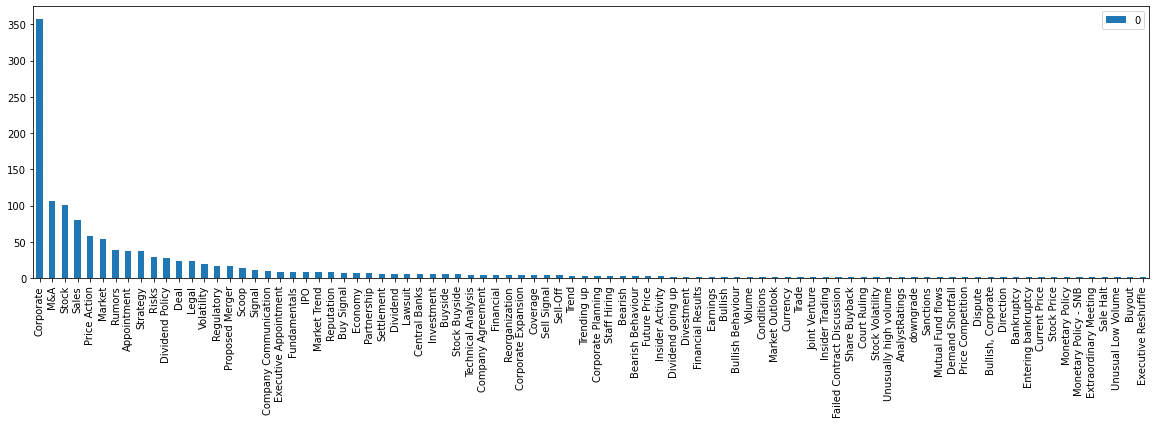

In [74]:
import collections 
counter=collections.Counter(flat_list)
counter = collections.OrderedDict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
del counter['?'] 
del counter[''] 
print(counter)
df = pd.DataFrame.from_dict(counter, orient='index')
df.plot(kind='bar', figsize = (20,5))

In [75]:
bad_chars = ['[', '\'', ']']
sentence = [''.join(i for i in test_string if not i in bad_chars) for test_string in sentence]

In [76]:
#create dataframe
train = pd.DataFrame({
    'sentence': sentence, 
    'aspects': aspects, 
    'target':target, 
    'sentiment_score':sentiment_score})
train.head()

,sentence,aspects,target,sentiment_score
0,set to step down,"[Corporate, Appointment]",Royal Mail,-0.374
1,Facing Tough Competition,"[Corporate, Risks]",AstraZeneca,-0.24
2,Crest loses a third of Morrisons milk contract,"[Corporate, Sales, Failed Contract Discussion]",Morrisons,-0.161
3,hires Avivas David Hillier for multi-asset team,"[Corporate, Appointment, Executive Appointment]",Insight,0.137
4,after strong sales,"[Corporate, Sales]",Primark,0.704


In [77]:
train = train.explode('aspects')
train.head()

,sentence,aspects,target,sentiment_score
0,set to step down,Corporate,Royal Mail,-0.374
0,set to step down,Appointment,Royal Mail,-0.374
1,Facing Tough Competition,Corporate,AstraZeneca,-0.24
1,Facing Tough Competition,Risks,AstraZeneca,-0.24
2,Crest loses a third of Morrisons milk contract,Corporate,Morrisons,-0.161


In [78]:
train = train.dropna()
train = train[~train.aspects.isin(['?', ''])]
train.shape

(1267, 4)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


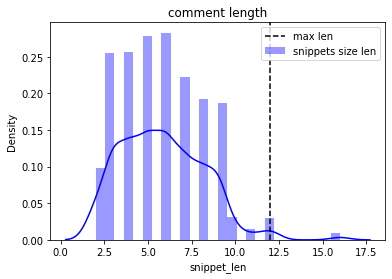

In [79]:
train['snippet_len'] = train.sentence.apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train.snippet_len.mean() + 2.5*train.snippet_len.std()).astype(int)

sns.distplot(train.snippet_len, hist=True, kde=True, color='b', label='snippets size len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1267 entries, 0 to 497
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentence         1267 non-null   object
 1   aspects          1267 non-null   object
 2   target           1267 non-null   object
 3   sentiment_score  1267 non-null   object
 4   snippet_len      1267 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 59.4+ KB


In [81]:
#creating auxiliary sentences
train['auxiliary'] = train.sentence + "." + " What do you think of " + train.aspects + " of the " + train.target

In [82]:
print(train.auxiliary.head())

0    set to step down. What do you think of Corpora...
0    set to step down. What do you think of Appoint...
1    Facing Tough Competition. What do you think of...
1    Facing Tough Competition. What do you think of...
2    Crest loses a third of Morrisons milk contract...
Name: auxiliary, dtype: object


In [83]:
#cols = ['auxiliary', 'sentiment_score']
#train = train[cols]

In [84]:
train.sentiment_score = pd.to_numeric(train.sentiment_score)
train.sentiment_score

0     -0.374
0     -0.374
1     -0.240
1     -0.240
2     -0.161
       ...  
496    0.435
496    0.435
497    0.259
497    0.259
497    0.259
Name: sentiment_score, Length: 1267, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


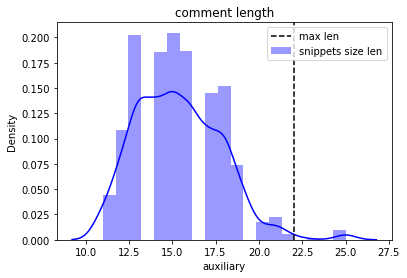

In [85]:
snippet_len = train.auxiliary.apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(snippet_len.mean() + 2.5*snippet_len.std()).astype(int)

sns.distplot(snippet_len, hist=True, kde=True, color='b', label='snippets size len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, train.sentiment_score.values,
                                                                      test_size=0.2, random_state=42) 

In [87]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1013, 6), (254, 6), (1013,), (254,))

In [88]:
X_train.head()

,sentence,aspects,target,sentiment_score,snippet_len,auxiliary
12,Group Sign Memo of Understanding ..,Strategy,China Merchants Group,0.119,6,Group Sign Memo of Understanding ... What do y...
64,share price climbs,Stock,Whitbread,0.513,3,share price climbs. What do you think of Stock...
286,Brazil to sue Samarco for Â£3.5bn,Lawsuit,Samarco,-0.637,6,Brazil to sue Samarco for Â£3.5bn. What do you...
377,after slashing dividend,Dividend Policy,BHP Billiton,-0.604,3,after slashing dividend. What do you think of ...
109,will not affect image of budget air trave,Corporate,easyJet,0.096,8,will not affect image of budget air trave. Wha...


## Loading Tokenizer and Encoding our Data

In [89]:
!pip install transformers

In [90]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [91]:
modeldir = "/content/drive/My Drive/praveen_iiit_hyd_ire_class/ten_k_project_work/tenkBERTv2Cased/"

In [92]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [93]:
batch_sentences = ["Hello I'm a single sentence",
                    "And another sentence",
                    "And the very very last one"]
encoded_input = tokenizer(batch_sentences)
print(encoded_input)

{'input_ids': [[101, 7592, 1045, 1005, 1049, 1037, 2309, 6251, 102], [101, 1998, 2178, 6251, 102], [101, 1998, 1996, 2200, 2200, 2197, 2028, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}


In [94]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.auxiliary.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=40, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val.auxiliary.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=40, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.FloatTensor(X_train.sentiment_score.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.FloatTensor(X_val.sentiment_score.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [95]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [96]:
len(dataset_train), len(dataset_val)

(1013, 254)

## Setting up BERT Pretrained Model

In [97]:
from transformers import BertForSequenceClassification

In [98]:
modeldir

'/content/drive/My Drive/praveen_iiit_hyd_ire_class/ten_k_project_work/tenkBERTv2Cased/'

In [99]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',# 'bert-base-uncased',
                                                      num_labels=1,
                                                      output_attentions=False,
                                                      output_hidden_states=False)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Creating Data Loaders

In [100]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [101]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

## Setting Up Optimiser and Scheduler

In [102]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [103]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [104]:
epochs = 15

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

*Accuracy* metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [105]:
import numpy as np

In [106]:
from sklearn.metrics import f1_score

In [107]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [108]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [109]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [111]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [112]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    #val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    #tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.14057204872369766
Validation loss: 0.12497400399297476



Epoch 2
Training loss: 0.10047329030930996
Validation loss: 0.07799804350361228



Epoch 3
Training loss: 0.07101828895974904
Validation loss: 0.05113406805321574



Epoch 4
Training loss: 0.046814755391096696
Validation loss: 0.040282681584358215



Epoch 5
Training loss: 0.03317139879800379
Validation loss: 0.03039994928985834



Epoch 6
Training loss: 0.02578228639322333
Validation loss: 0.025946989189833403



Epoch 7
Training loss: 0.022505413042381406
Validation loss: 0.022111158818006516



Epoch 8
Training loss: 0.01794769224943593
Validation loss: 0.01814248040318489



Epoch 9
Training loss: 0.015795552550116554
Validation loss: 0.01751321495976299



Epoch 10
Training loss: 0.015123445395147428
Validation loss: 0.01772183331195265



Epoch 11
Training loss: 0.014085616916418076
Validation loss: 0.01474217779468745



Epoch 12
Training loss: 0.013453003426548094
Validation loss: 0.014651646197307855



Epoch 13
Training loss: 0.012587433753651567
Validation loss: 0.01274001837009564



Epoch 14
Training loss: 0.011145427415613085
Validation loss: 0.012890522310044616



Epoch 15
Training loss: 0.01221007875574287
Validation loss: 0.013123846671078354



In [113]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), (y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [114]:
def mse(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), (y_pred)
    return np.mean(np.power((y_true - y_pred),2)) * 100

In [121]:
_, predictions, true_vals = evaluate(dataloader_train)

In [122]:
mean_absolute_percentage_error(true_vals, predictions.ravel())

0.11126822791993618

In [124]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [125]:
mean_absolute_percentage_error(true_vals, predictions.ravel())

0.15826757298782468

In [119]:
X_val['pred'] = predictions.ravel()
X_val.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sentence,aspects,target,sentiment_score,snippet_len,auxiliary,pred
476,3 must-have growth stocks?,Rumors,Domino's Pizza Group plc,0.063,4,3 must-have growth stocks?. What do you think ...,-0.012695
410,Lender Cuts Dividends to Shore Up Capita,Corporate,Barclays,0.261,7,Lender Cuts Dividends to Shore Up Capita. What...,-0.014951
167,Sales boost,Corporate,Tesco,-0.410,2,Sales boost. What do you think of Corporate of...,0.089021
438,Sees Baxalta Deal Closing as Expected,Sales,Shire,0.224,6,Sees Baxalta Deal Closing as Expected. What do...,0.177946
333,Can Christmas Save..... ?,Rumors,Tesco,-0.175,4,Can Christmas Save..... ?. What do you think o...,-0.104399
309,wipes out sales gains for SABMiller,Corporate,SABMiller,-0.582,6,wipes out sales gains for SABMiller. What do y...,-0.594334
9,Tesco leads leap in FTSE 100;,Technical Analysis,Tesco,0.389,7,Tesco leads leap in FTSE 100; . What do you th...,0.356451
159,extends gas deals,Deal,Statoil,0.239,3,extends gas deals. What do you think of Deal o...,0.247464
17,Tesco Abandons Video-Streaming Ambitions,Corporate,Tesco,-0.335,5,Tesco Abandons Video-Streaming Ambitions . Wha...,-0.125016
229,still paying price for dividend cut,Corporate,L&G,-0.338,6,still paying price for dividend cut. What do y...,-0.510839
